## Imports

In [17]:
import os
import optuna
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torch import nn
import albumentations as A

import torch
from torch.utils.data import Dataset, DataLoader

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss


## Data Loader

In [2]:
class WaterBodiesDataset(Dataset):
    def __init__(self, data_dir, split="train", test_size=0.15, val_size=0.15, transform=None):

        assert split in ["train", "val", "test"], "Split must be 'train', 'val' or 'test'"
        
        image_paths = sorted(glob.glob(os.path.join(data_dir, "Images", "*.jpg")))
        mask_paths = sorted(glob.glob(os.path.join(data_dir, "Masks", "*.jpg")))

        assert len(image_paths) == len(mask_paths), "Mismatch between images and masks count!"

        total_size = len(image_paths)
        test_count = int(test_size * total_size)
        val_count = int(val_size * total_size) 
        train_count = total_size - test_count - val_count  

        if split == "test":
            selected_indices = list(range(test_count))
        elif split == "val":
            selected_indices = list(range(test_count + train_count, total_size))
        else: 
            selected_indices = list(range(test_count, test_count + train_count))

        self.image_paths = [image_paths[i] for i in selected_indices]
        self.mask_paths = [mask_paths[i] for i in selected_indices]
        self.transform = A.Compose([
            A.Resize(256, 256),
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx])
        mask = Image.open(self.mask_paths[idx]).convert('L')
        
        img, mask = np.array(img), np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask

In [3]:
def get_dataloaders(data_dir, batch_size=32, shuffle=True, num_workers=0):
    train_dataset = WaterBodiesDataset(data_dir, split="train")
    val_dataset = WaterBodiesDataset(data_dir, split="val")
    test_dataset = WaterBodiesDataset(data_dir, split="test")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    print(f'Train dataset: {len(train_dataset)}')
    print(f'Test dataset: {len(test_dataset)}')
    print(f'Val dataset: {len(val_dataset)}')

    return train_loader, val_loader, test_loader

In [4]:
train_dataloader, val_dataloader, test_dataloader = get_dataloaders('../data/WaterBodiesDataset')

assert len(train_dataloader) > 0
assert len(val_dataloader) > 0 
assert len(test_dataloader) > 0

Train dataset: 1989
Test dataset: 426
Val dataset: 426


## 1. Data Analysis
* Load and display a few sample satellite images along with their corresponding segmentation masks.
* Check the dimensions of the images and masks, as well as the number of color channels.
* Based on the masks, calculate what percentage of each image is covered by water. Provide the average percentage across the entire dataset.
* Visualize the distribution of water coverage in the dataset using a histogram: group images into bins (0–9%, 10–19%, 20–29%, etc.).
* What additional insights can be gained from data visualization? Choose one interesting feature and present it in a chart.


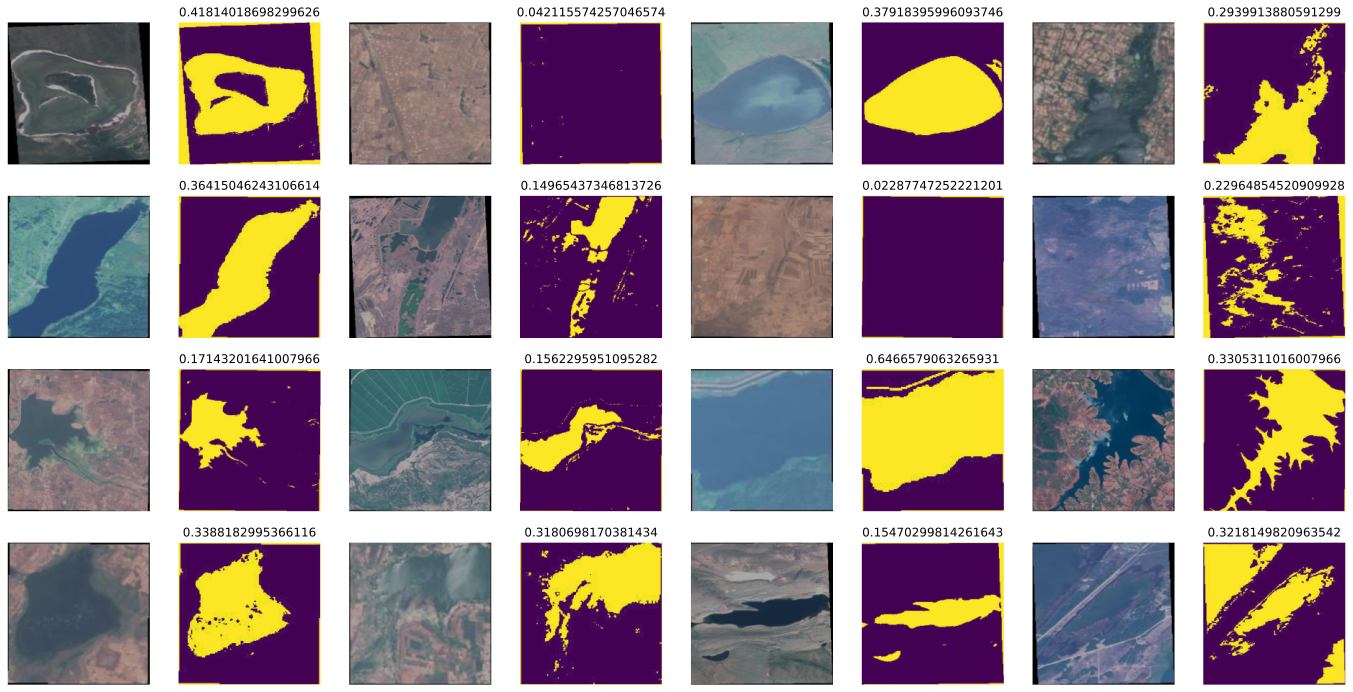

In [5]:
img, mask = next(iter(train_dataloader))

axes = plt.subplots(4, 8, figsize=(24, 12))[1].flatten()
for i in range(16):
	axes[2*i].imshow(img[i].permute(1, 2, 0).numpy())
	axes[2*i].axis('off')

	axes[2*i+1].imshow(mask[i].permute(1, 2, 0).numpy())
	axes[2*i+1].axis('off')
	axes[2*i+1].set_title(f'{mask[i].mean()}')

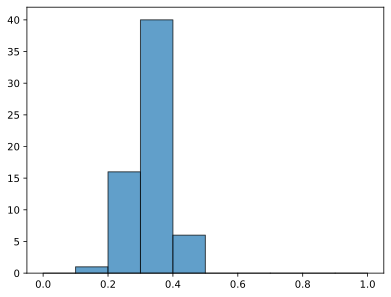

In [6]:
water_levels = [mask.mean() for img, mask in train_dataloader]
plt.hist(water_levels, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
plt.show()

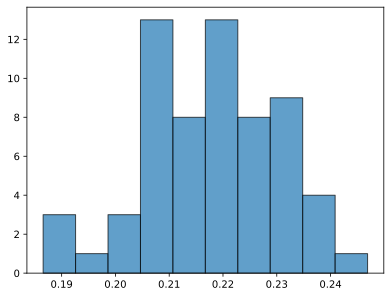

In [7]:
water_variance = [mask.var() for img, mask in train_dataloader]
plt.hist(water_variance, bins=10, edgecolor='black', alpha=0.7)
plt.show()

## 2. Model Training with PyTorch
* Train a segmentation model capable of detecting water areas. You may use the provided code for creating DataLoaders and the model, or refer to the lecture materials.
* Report the model’s accuracy and visualize the results.
* Save the best model weights and ensure they can be reloaded—if a weight file exists, the model should initialize with those weights on the next run.

In [23]:
from torch.utils.tensorboard import SummaryWriter
# default `log_dir` is "runs" - we'll be more specific here

class Model:
	def __class_getitem__(cls, base_class):
		class DynamicSubclass(base_class, Model):
			...
		return DynamicSubclass

	def save(self, filepath: str):
		torch.save(self.state_dict(), filepath)
	
	def load(self, filepath: str):
		try:
			self.load_state_dict(torch.load(filepath))
		except FileNotFoundError as e:
			print(e)

	def fit(self, dataloader: DataLoader, loss_function = DiceLoss(mode='binary'), lr=1e-4, epochs=1, writer: str=None):
		if writer:
			writer = SummaryWriter(f'runs/{writer}')
		optimizer = torch.optim.Adam(self.parameters(), lr=lr)
		best_weights = self.state_dict()
		lowest_epoch_loss = np.inf
		for epoch in range(epochs):
			self.train().cuda()
			running_loss = 0.0

			for i, (images, masks) in enumerate(tqdm(dataloader)):
				images, masks = images.float().cuda(), masks.float().cuda()
				optimizer.zero_grad()
				outputs = self(images)
				loss = loss_function(outputs, masks)
				loss.backward()
				optimizer.step()
				running_loss += loss.item()
				if writer:
					writer.add_scalar('training loss', loss.item(), i*(epoch+1))
			
			epoch_loss = running_loss/len(dataloader)
			if epoch_loss < lowest_epoch_loss:
				lowest_epoch_loss = epoch_loss
				best_weights = self.state_dict().copy()

			print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}")
		self.load_state_dict(best_weights)

In [9]:
model = Model[smp.Unet](
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
)
model.load("segmentation_model.pth")

In [10]:
model.fit(train_dataloader, epochs=5)
model.save("segmentation_model.pth")

100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


Epoch 1/5, Loss: 0.4876996647743952


100%|██████████| 63/63 [00:42<00:00,  1.47it/s]


Epoch 2/5, Loss: 0.4841980498934549


100%|██████████| 63/63 [00:42<00:00,  1.48it/s]


Epoch 3/5, Loss: 0.48668964420046124


100%|██████████| 63/63 [00:50<00:00,  1.25it/s]


Epoch 4/5, Loss: 0.4812894217551701


100%|██████████| 63/63 [00:58<00:00,  1.08it/s]


Epoch 5/5, Loss: 0.48442409625129096


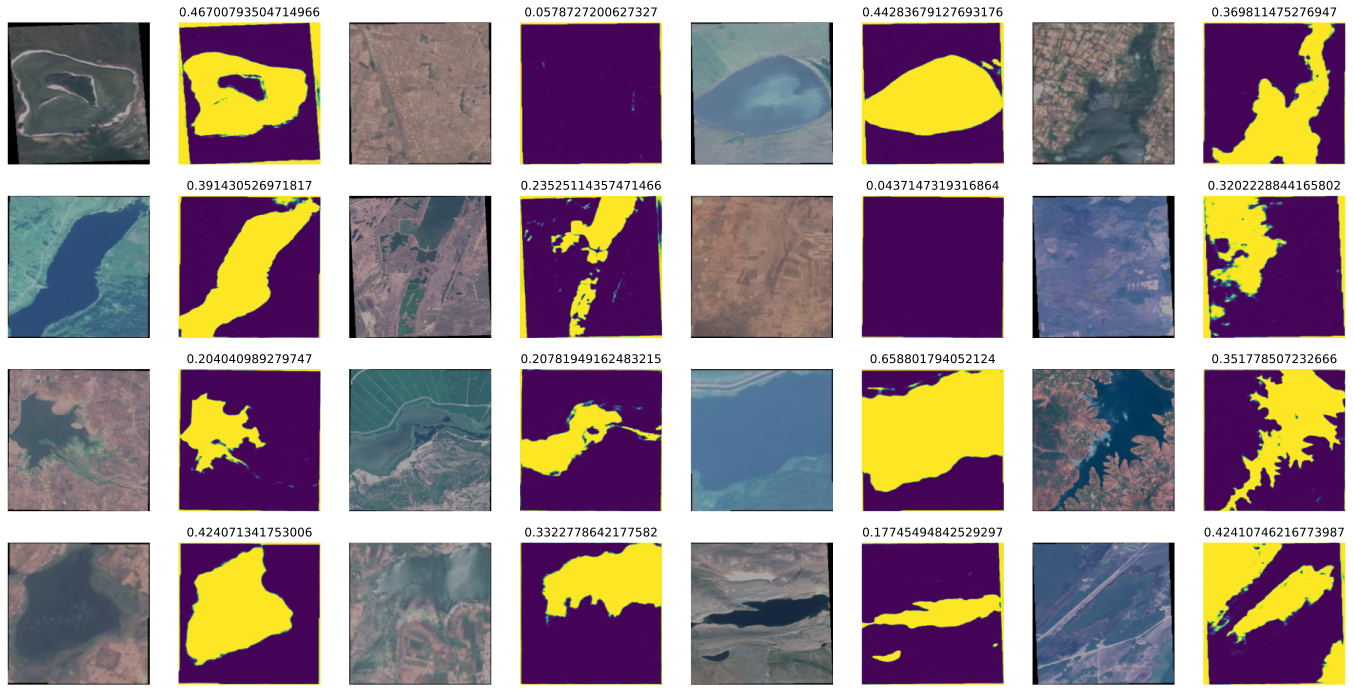

In [13]:
preds = model(img.float().cuda()).detach().cpu()

axes = plt.subplots(4, 8, figsize=(24, 12))[1].flatten()
for i in range(16):
	axes[2*i].imshow(img[i].permute(1, 2, 0).numpy())
	axes[2*i].axis('off')

	axes[2*i+1].imshow(preds[i].permute(1, 2, 0).numpy())
	axes[2*i+1].axis('off')
	axes[2*i+1].set_title(f'{preds[i].mean()}')

In [14]:
1 - np.abs(mask.round() - preds.round()).mean()

/tmp/ipykernel_17103/4257418339.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  1 - np.abs(mask.round() - preds.round()).mean()


tensor(0.9285, dtype=torch.float64)

## 3. Model training and tracking
- Use Optuna to determine which loss function performs better. Compare, for example, DiceLoss (from segmentation_models_pytorch.losses) and nn.BCEWithLogitsLoss(). Tune the learning rate as well. Perform at least 10 trials in the optimization experiment.
- Log training information to a selected tool (Weights & Biases or TensorBoard). Track and log loss and accuracy throughout the training process. Every few iterations, log visualizations of the model's predictions: original images and their corresponding predicted segmentation masks.

In [21]:
from segmentation_models_pytorch.losses import DiceLoss, SoftBCEWithLogitsLoss

def objective(trial):
	losses = dict(
		dice=DiceLoss(mode="binary"), 
		bce=SoftBCEWithLogitsLoss()
	)
	lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
	lf = trial.suggest_categorical("lf", losses.keys())

	model = Model[smp.Unet](
		encoder_name="resnet50",
		encoder_weights="imagenet",
		in_channels=3,
		classes=1,
		activation="sigmoid"
	)
	model.load("segmentation_model.pth")
	model.fit(train_dataloader, epochs=1, lr=lr, loss_function=losses[lf], writer=f'lr: {lr}\tlf: {lf}')
	return 1 - np.abs(mask.round() - preds.round()).mean()

In [25]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2025-03-06 22:18:57,828] A new study created in memory with name: no-name-7e4f8bc7-b8a6-4fc9-b1da-f37720e8d845
/tmp/ipykernel_17103/3256833580.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("lr", 1e-5, 1e-2)
100%|██████████| 63/63 [00:39<00:00,  1.59it/s]
/tmp/ipykernel_17103/3256833580.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return 1 - np.abs(mask.round() - preds.round()).mean()
[I 2025-03-06 22:19:38,093] Trial 0 finished with value: 0.9285216331481934 and parameters: {'lr': 0.0007911608478255261, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6269254854747227


100%|██████████| 63/63 [00:40<00:00,  1.54it/s]
[I 2025-03-06 22:20:19,508] Trial 1 finished with value: 0.9285216331481934 and parameters: {'lr': 0.0021960651589449853, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6496846363657997


100%|██████████| 63/63 [00:41<00:00,  1.51it/s]
[I 2025-03-06 22:21:01,832] Trial 2 finished with value: 0.9285216331481934 and parameters: {'lr': 0.00718846605847182, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6737444675157941


100%|██████████| 63/63 [00:48<00:00,  1.31it/s]
[I 2025-03-06 22:21:50,586] Trial 3 finished with value: 0.9285216331481934 and parameters: {'lr': 0.002053245273076753, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6454320691880726


100%|██████████| 63/63 [00:52<00:00,  1.21it/s]
[I 2025-03-06 22:22:43,470] Trial 4 finished with value: 0.9285216331481934 and parameters: {'lr': 0.004927229542602596, 'lf': 'dice'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.512538438751584


100%|██████████| 63/63 [00:54<00:00,  1.16it/s]
[I 2025-03-06 22:23:38,347] Trial 5 finished with value: 0.9285216331481934 and parameters: {'lr': 0.0018319013234107495, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6434248146556673


100%|██████████| 63/63 [00:57<00:00,  1.10it/s]
[I 2025-03-06 22:24:36,386] Trial 6 finished with value: 0.9285216331481934 and parameters: {'lr': 3.4928849901513894e-05, 'lf': 'dice'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.4806964586651514


100%|██████████| 63/63 [00:56<00:00,  1.11it/s]
[I 2025-03-06 22:25:33,573] Trial 7 finished with value: 0.9285216331481934 and parameters: {'lr': 0.00030772217350599805, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6144070256324041


100%|██████████| 63/63 [00:56<00:00,  1.11it/s]
[I 2025-03-06 22:26:30,917] Trial 8 finished with value: 0.9285216331481934 and parameters: {'lr': 0.0005678497853453493, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6225576741354806


100%|██████████| 63/63 [00:55<00:00,  1.14it/s]
[I 2025-03-06 22:27:26,682] Trial 9 finished with value: 0.9285216331481934 and parameters: {'lr': 3.919958971700316e-05, 'lf': 'bce'}. Best is trial 0 with value: 0.9285216331481934.


Epoch 1/1, Loss: 0.6005690788465833


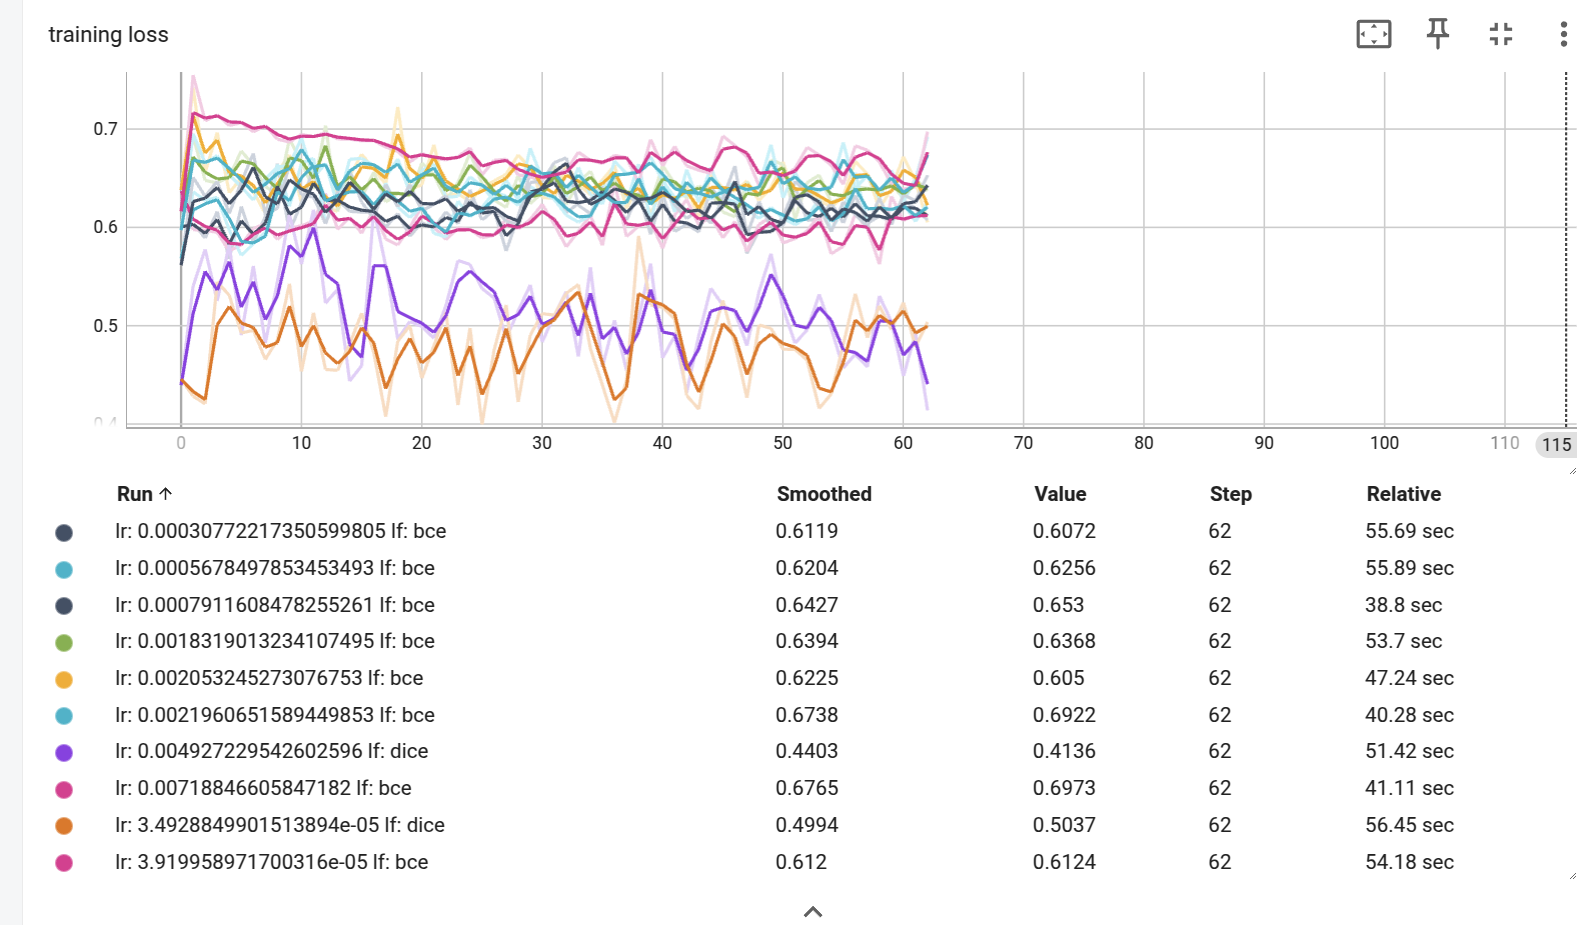